Importing necessary libraries and dataset

In [1]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Load the dataset
df = pd.read_csv("onlinefraud.csv")

#Disply first few rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Verifying the data

In [3]:
df.info()
df.describe()
print("Missing values per columns:\n", df.isnull().sum()) #Check for missing values
print("\nNumber of duplicate Rows:", df.duplicated().sum()) #Check for duplicate values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Missing values per columns:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Number of duplicate Rows: 0


In [4]:
# Convert categorical variables into numerical values
df_encoded = df.copy()

# Identify categorical columns
categorical_cols = df_encoded.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical variables
label_encoder = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

Distribution of Fraudulent vs. Non-Fraudulent Transactions

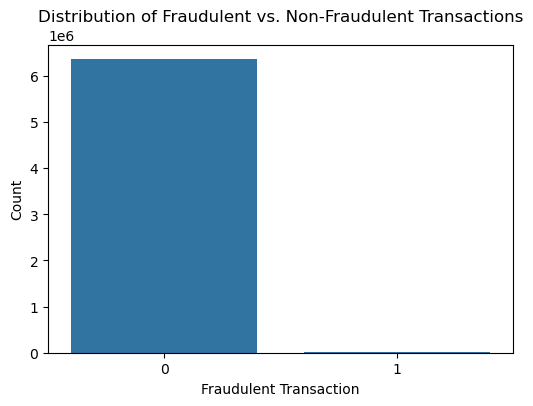

In [5]:
# Count of fraud vs non-fraud transactions
plt.figure(figsize=(6,4))
sns.countplot(x="isFraud", data=df)
plt.title("Distribution of Fraudulent vs. Non-Fraudulent Transactions")
plt.xlabel("Fraudulent Transaction")
plt.ylabel("Count")
plt.show()

#This plot shows the proportion of fraudulent transactions in the dataset

Summary Table: Fraudlent vs. non-Fraudulent Transactions

In [6]:
# Compute summary statistics for fraudulent vs. non-fraudulent transactions
fraud_summary = df.groupby("isFraud").agg({
    "amount": ["mean", "median", "std", "min", "max"],
    "oldbalanceOrg": ["mean", "median", "std", "min", "max"],
    "newbalanceOrig": ["mean", "median", "std", "min", "max"],
    "oldbalanceDest": ["mean", "median", "std", "min", "max"],
    "newbalanceDest": ["mean", "median", "std", "min", "max"]
}).round(2)

# Rename columns for readability
fraud_summary.columns = [
    "Amount Mean", "Amount Median", "Amount Std Dev", "Amount Min", "Amount Max",
    "Old Balance Origin Mean", "Old Balance Origin Median", "Old Balance Origin Std Dev", "Old Balance Origin Min", "Old Balance Origin Max",
    "New Balance Origin Mean", "New Balance Origin Median", "New Balance Origin Std Dev", "New Balance Origin Min", "New Balance Origin Max",
    "Old Balance Destination Mean", "Old Balance Destination Median", "Old Balance Destination Std Dev", "Old Balance Destination Min", "Old Balance Destination Max",
    "New Balance Destination Mean", "New Balance Destination Median", "New Balance Destination Std Dev", "New Balance Destination Min", "New Balance Destination Max"
]

# Display the table
print("\n### Fraudulent vs. Non-Fraudulent Transactions Summary ###\n")
print(fraud_summary.to_markdown())


### Fraudulent vs. Non-Fraudulent Transactions Summary ###

|   isFraud |      Amount Mean |   Amount Median |   Amount Std Dev |   Amount Min |   Amount Max |   Old Balance Origin Mean |   Old Balance Origin Median |   Old Balance Origin Std Dev |   Old Balance Origin Min |   Old Balance Origin Max |   New Balance Origin Mean |   New Balance Origin Median |   New Balance Origin Std Dev |   New Balance Origin Min |   New Balance Origin Max |   Old Balance Destination Mean |   Old Balance Destination Median |   Old Balance Destination Std Dev |   Old Balance Destination Min |   Old Balance Destination Max |   New Balance Destination Mean |   New Balance Destination Median |   New Balance Destination Std Dev |   New Balance Destination Min |   New Balance Destination Max |
|----------:|-----------------:|----------------:|-----------------:|-------------:|-------------:|--------------------------:|----------------------------:|-----------------------------:|-------------------------:|--

Distribution of Transaction Amounts

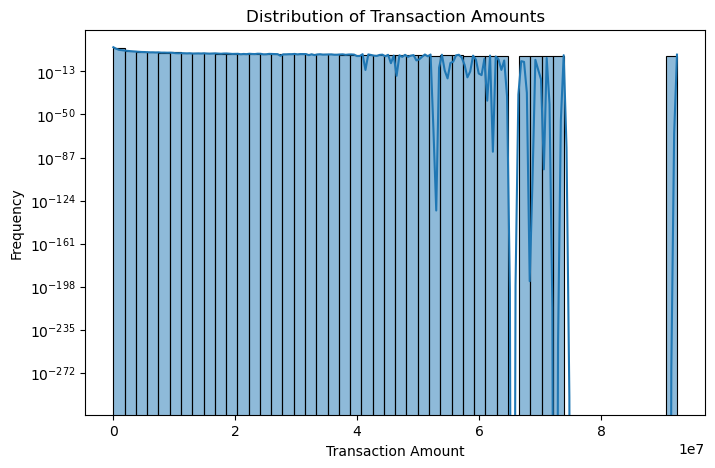

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df["amount"], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.yscale("log")  # Log scale to handle skewed data
plt.show()

Transaction Amount vs. Fraud Occurence

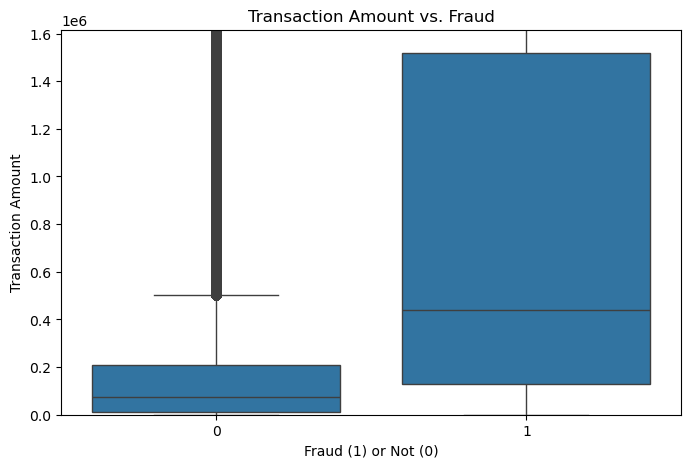

In [8]:
#Examining whether transaction amounts influence fraud likelihood
plt.figure(figsize=(8,5))
sns.boxplot(x="isFraud", y="amount", data=df)
plt.ylim(0, df["amount"].quantile(0.99))  # Remove extreme outliers
plt.title("Transaction Amount vs. Fraud")
plt.xlabel("Fraud (1) or Not (0)")
plt.ylabel("Transaction Amount")
plt.show()
#Outliers may indicate potential fraudulent activities

Fraud Rate by Transaction type

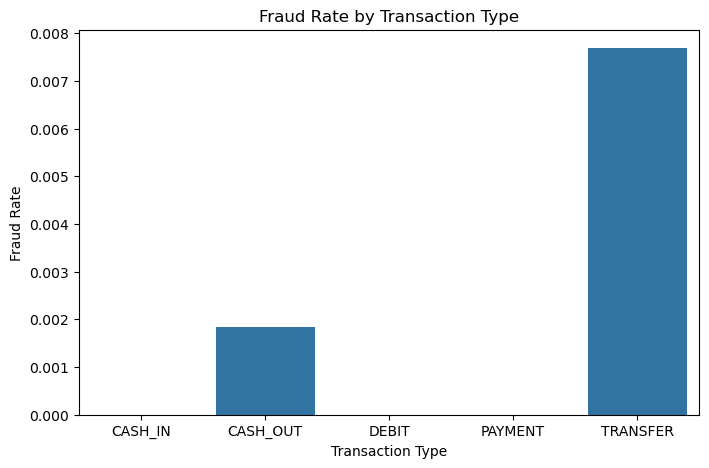

In [9]:
#Fraud Rate
fraud_rate = df.groupby("type")["isFraud"].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x="type", y="isFraud", data=fraud_rate)
plt.title("Fraud Rate by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Fraud Rate")
plt.show()

Flagged Transactions and Fraud

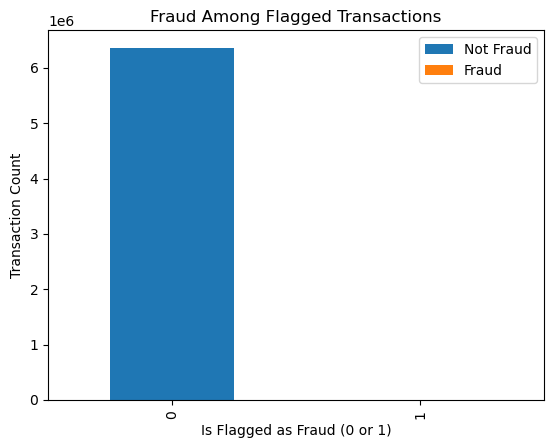

In [10]:
#Checking how Flagged transactions correlate with Fraud
df.groupby("isFlaggedFraud")["isFraud"].value_counts().unstack().plot(kind="bar", stacked=True)
plt.title("Fraud Among Flagged Transactions")
plt.xlabel("Is Flagged as Fraud (0 or 1)")
plt.ylabel("Transaction Count")
plt.legend(["Not Fraud", "Fraud"])
plt.show()

Summary Table: Flagged vs. Non Flagged Transactions

In [11]:
# Compute summary statistics for flagged vs. non-flagged transactions
flagged_summary = df.groupby("isFlaggedFraud").agg({
    "amount": ["mean", "median", "std", "min", "max"],
    "oldbalanceOrg": ["mean", "median", "std", "min", "max"],
    "newbalanceOrig": ["mean", "median", "std", "min", "max"],
    "oldbalanceDest": ["mean", "median", "std", "min", "max"],
    "newbalanceDest": ["mean", "median", "std", "min", "max"]
}).round(2)

# Use the same column names as before for consistency
flagged_summary.columns = fraud_summary.columns

# Display the table
print("\n### Flagged vs. Non-Flagged Transactions Summary ###\n")
print(flagged_summary.to_markdown())


### Flagged vs. Non-Flagged Transactions Summary ###

|   isFlaggedFraud |     Amount Mean |   Amount Median |   Amount Std Dev |   Amount Min |   Amount Max |   Old Balance Origin Mean |   Old Balance Origin Median |   Old Balance Origin Std Dev |   Old Balance Origin Min |   Old Balance Origin Max |   New Balance Origin Mean |   New Balance Origin Median |   New Balance Origin Std Dev |   New Balance Origin Min |   New Balance Origin Max |   Old Balance Destination Mean |   Old Balance Destination Median |   Old Balance Destination Std Dev |   Old Balance Destination Min |   Old Balance Destination Max |   New Balance Destination Mean |   New Balance Destination Median |   New Balance Destination Std Dev |   New Balance Destination Min |   New Balance Destination Max |
|-----------------:|----------------:|----------------:|-----------------:|-------------:|-------------:|--------------------------:|----------------------------:|-----------------------------:|-----------------------

Summary table: Flagged Fraudulent vs. Flagged Non-Fraudulent transactions

In [12]:
# Compute summary statistics for flagged fraudulent transactions
flagged_fraud_summary = df[df["isFlaggedFraud"] == 1].groupby("isFraud").agg({
    "amount": ["mean", "median", "std", "min", "max"],
    "oldbalanceOrg": ["mean", "median", "std", "min", "max"],
    "newbalanceOrig": ["mean", "median", "std", "min", "max"],
    "oldbalanceDest": ["mean", "median", "std", "min", "max"],
    "newbalanceDest": ["mean", "median", "std", "min", "max"]
}).round(2)

# Use the same column names for consistency
flagged_fraud_summary.columns = fraud_summary.columns

# Display the table
print("\n### Flagged Fraudulent vs. Flagged Non-Fraudulent Transactions Summary ###\n")
print(flagged_fraud_summary.to_markdown())


### Flagged Fraudulent vs. Flagged Non-Fraudulent Transactions Summary ###

|   isFraud |   Amount Mean |   Amount Median |   Amount Std Dev |   Amount Min |   Amount Max |   Old Balance Origin Mean |   Old Balance Origin Median |   Old Balance Origin Std Dev |   Old Balance Origin Min |   Old Balance Origin Max |   New Balance Origin Mean |   New Balance Origin Median |   New Balance Origin Std Dev |   New Balance Origin Min |   New Balance Origin Max |   Old Balance Destination Mean |   Old Balance Destination Median |   Old Balance Destination Std Dev |   Old Balance Destination Min |   Old Balance Destination Max |   New Balance Destination Mean |   New Balance Destination Median |   New Balance Destination Std Dev |   New Balance Destination Min |   New Balance Destination Max |
|----------:|--------------:|----------------:|-----------------:|-------------:|-------------:|--------------------------:|----------------------------:|-----------------------------:|-------------------

Correlation Heatmap

In [13]:
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [14]:
from sklearn.preprocessing import LabelEncoder

# Apply LabelEncoder to each categorical column
label_encoder = LabelEncoder()

for col in non_numeric_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [15]:
print(df.dtypes)  # Make sure all columns are numeric

step                int64
type                int64
amount            float64
nameOrig            int64
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest            int64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


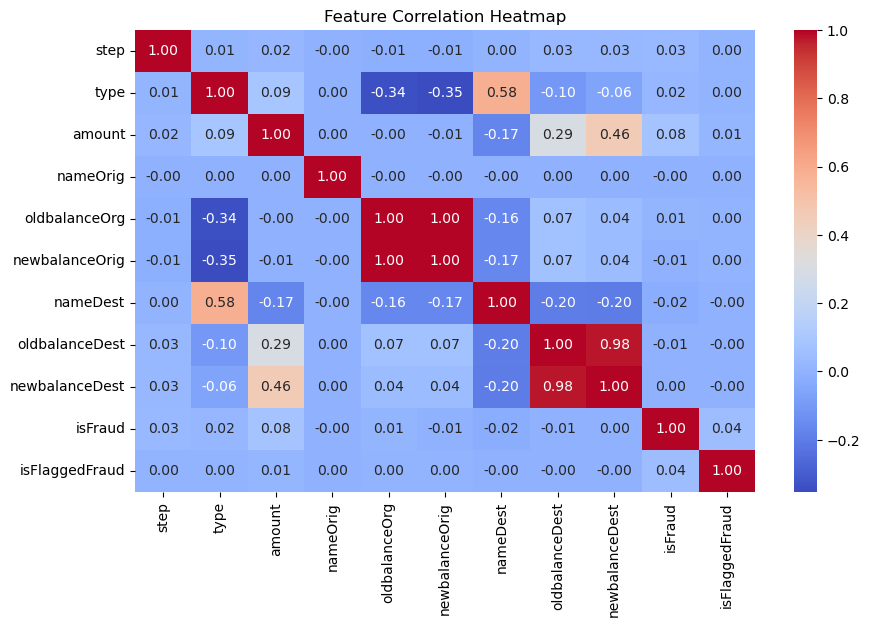

In [16]:
#Understanding future relationships
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Define Hypotheses
Perform statistical tests for each hypothesis
Check assumptions

Correlation Matrix:
                   amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
amount          1.000000      -0.002762       -0.007861        0.294137   
oldbalanceOrg  -0.002762       1.000000        0.998803        0.066243   
newbalanceOrig -0.007861       0.998803        1.000000        0.067812   
oldbalanceDest  0.294137       0.066243        0.067812        1.000000   
newbalanceDest  0.459304       0.042029        0.041837        0.976569   

                newbalanceDest  
amount                0.459304  
oldbalanceOrg         0.042029  
newbalanceOrig        0.041837  
oldbalanceDest        0.976569  
newbalanceDest        1.000000  
Optimization terminated successfully.
         Current function value: 0.008597
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                isFraud   No. Observations:              6362620
Model:                          Logit   Df Residuals:                

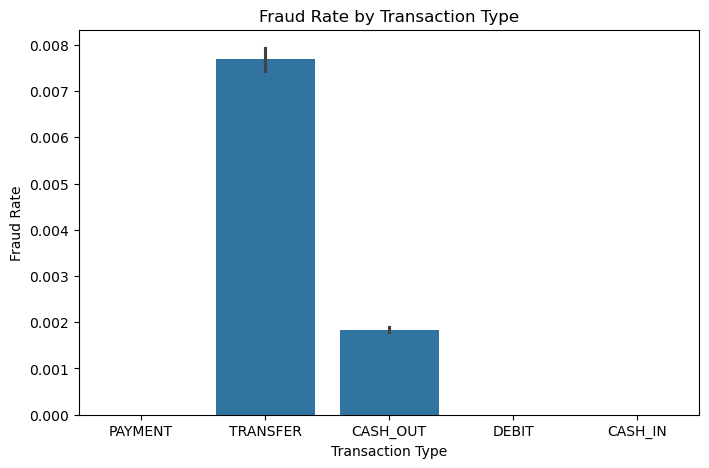

Shapiro-Wilk Test for Flagged Transactions: p-value = 0.06263886422849416
Shapiro-Wilk Test for Non-Flagged Transactions: p-value = 2.8695529534012235e-34
Mann-Whitney U Test Results: p-value = 2.2134966697650238e-11


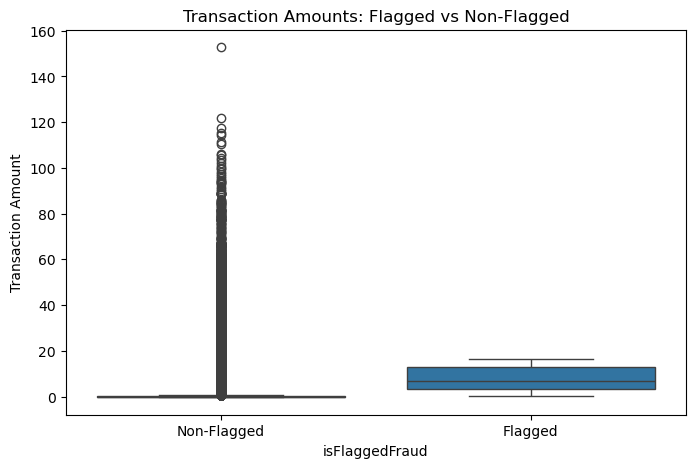

Chi-Square Test for Flagged Fraudulent vs. Flagged Non-Fraudulent Transactions: p-value = 1.0
Mean transaction amount (Flagged Fraudulent): 7.753038629022491
Mean transaction amount (Flagged Non-Fraudulent): nan


/var/folders/yh/q29t0rh92yq9ns3kfy5329gw0000gn/T/ipykernel_1903/1618333746.py:99: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.countplot(x="type", hue="isFraud", data=df[df['isFlaggedFraud'] == 1],


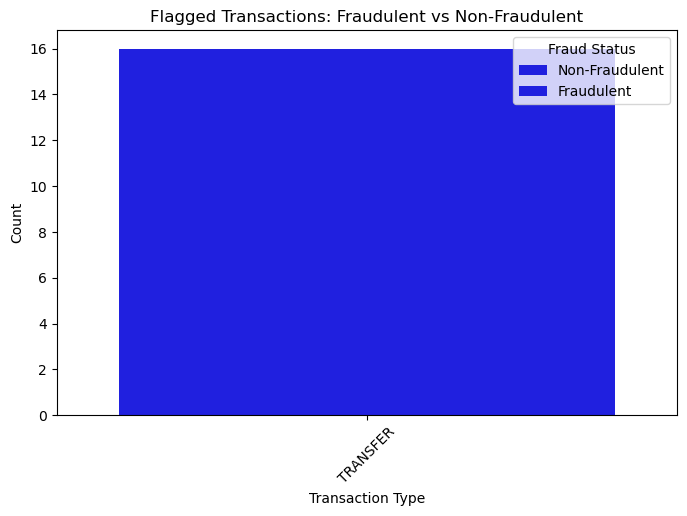

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("onlinefraud.csv")  # Update with correct file path

# Ensure fraud column is binary
df['isFraud'] = df['isFraud'].astype(int)
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype(int)

### 🔹 Fix: Normalize Feature Values to Prevent Overflows
scaler = StandardScaler()
df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(
    df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
)

### 🔹 Hypothesis 1: Key Factors Influencing Fraudulent Transactions
# 🔹 Fix: Drop Highly Correlated Features
corr_matrix = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].corr()
print("Correlation Matrix:\n", corr_matrix)

# Drop 'newbalanceOrig' since it's highly correlated with 'oldbalanceOrg'
X = df[['amount', 'oldbalanceOrg', 'newbalanceDest']]
X = sm.add_constant(X)  # Adding constant for regression
y = df['isFraud']  # Dependent variable

# Logistic Regression Model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print summary to identify significant factors
print(result.summary())

# Visualization: Fraud rates per transaction type
plt.figure(figsize=(8,5))
sns.barplot(x=df["type"], y=df["isFraud"])
plt.title("Fraud Rate by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Fraud Rate")
plt.show()

### 🔹 Hypothesis 2: Transaction Amount & Fraudulent Flagging
flagged = df[df['isFlaggedFraud'] == 1]['amount']
non_flagged = df[df['isFlaggedFraud'] == 0]['amount']

# Check normality (Shapiro-Wilk Test)
shapiro_flagged = stats.shapiro(flagged.sample(min(500, len(flagged)), random_state=42))  # Sample if large
shapiro_nonflagged = stats.shapiro(non_flagged.sample(min(500, len(non_flagged)), random_state=42))

print(f"Shapiro-Wilk Test for Flagged Transactions: p-value = {shapiro_flagged.pvalue}")
print(f"Shapiro-Wilk Test for Non-Flagged Transactions: p-value = {shapiro_nonflagged.pvalue}")

# If normality holds, perform t-test, else use Mann-Whitney U test
if shapiro_flagged.pvalue > 0.05 and shapiro_nonflagged.pvalue > 0.05:
    t_stat, p_value = stats.ttest_ind(flagged, non_flagged, equal_var=False)
    test_used = "T-test"
else:
    t_stat, p_value = stats.mannwhitneyu(flagged, non_flagged)
    test_used = "Mann-Whitney U Test"

print(f"{test_used} Results: p-value = {p_value}")

# Visualization
plt.figure(figsize=(8,5))
sns.boxplot(x=df["isFlaggedFraud"], y=df["amount"])
plt.title("Transaction Amounts: Flagged vs Non-Flagged")
plt.xticks([0,1], ["Non-Flagged", "Flagged"])
plt.ylabel("Transaction Amount")
plt.show()

### 🔹 Hypothesis 3: Differences in Flagged Transactions
flagged_fraud = df[(df['isFlaggedFraud'] == 1) & (df['isFraud'] == 1)]
flagged_nonfraud = df[(df['isFlaggedFraud'] == 1) & (df['isFraud'] == 0)]

# Compare categorical features (e.g., transaction type) using Chi-Square Test
contingency_table = pd.crosstab(df[df['isFlaggedFraud'] == 1]['type'], df[df['isFlaggedFraud'] == 1]['isFraud'])
chi2_stat, chi2_p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test for Flagged Fraudulent vs. Flagged Non-Fraudulent Transactions: p-value = {chi2_p}")

# Descriptive statistics for numerical features
print("Mean transaction amount (Flagged Fraudulent):", flagged_fraud['amount'].mean())
print("Mean transaction amount (Flagged Non-Fraudulent):", flagged_nonfraud['amount'].mean())

# Create a color palette with distinct colors
colors = ["blue", "red"]  # Blue for Non-Fraud, Red for Fraud

# Visualization: Fraudulent vs Non-Fraudulent flagged transactions by transaction type
plt.figure(figsize=(8,5))

# Use distinct colors for Non-Fraudulent (0) and Fraudulent (1) transactions
sns.countplot(x="type", hue="isFraud", data=df[df['isFlaggedFraud'] == 1], 
              palette=colors)  # Seaborn will auto-map 0 to blue and 1 to red

# Formatting the plot
plt.title("Flagged Transactions: Fraudulent vs Non-Fraudulent")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.legend(["Non-Fraudulent", "Fraudulent"], title="Fraud Status", loc="upper right")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

In [30]:
print(df[df['isFlaggedFraud'] == 1]['isFraud'].value_counts())

isFraud
1    16
Name: count, dtype: int64
